# Invariant Scattering Convolution Networks

Implémentation (partielle) de l'algorithme décrit dans l'article de S. Mallat et J. Bruno, $\textbf{Invariant Scattering Convolution Networks}$ (2013).

In [7]:
%matplotlib inline
%load_ext line_profiler

import os
from mnist import MNIST
import numpy as np
from scipy import signal, misc, ndimage
from itertools import combinations
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import sklearn.metrics as skmetrics

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


## 1. Morlet Wavelet

In [2]:
def Morlet2D_grid(n_lines, n_columns, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """returns 2d Morlet real and imaginary filter of size (n_lines, n_columns), rotated by theta and dilated by 1/2^J"""
    X = np.arange(-n_columns / 2**(J+1), n_columns / 2**(J+1), 1/2**J) #to get n_columns length vector
    Y = np.arange(-n_lines / 2**(J+1), n_lines / 2**(J+1), 1/2**J)
    X, Y = np.meshgrid(X, Y)
    
    # Rotate
    X_theta = np.cos(theta) * X + np.sin(theta) * Y 
    Y_theta = np.cos(theta) * Y - np.sin(theta) * X
    
    Wave = np.exp(1j * xi * (X_theta + Y_theta))
    Z_r = np.real(Wave)
    Z_i = np.imag(Wave)
    Gaus = np.exp(-np.sqrt(X_theta**2 + Y_theta**2) / (2 * sigma**2))
    Z_r *= Gaus
    Z_i *= Gaus
    
    # Center Morlet wave
    Int_r = np.sum(Z_r)
    Int_i = np.sum(Z_i)
    Int_Gaus = np.sum(Gaus)

    beta_r = Int_r / Int_Gaus
    beta_i = Int_i/ Int_Gaus
    
    Z_r -= beta_r * Gaus
    Z_i -= beta_i * Gaus
    return(Z_r + 1j * Z_i)

### Representation d'une ondelette Morlet

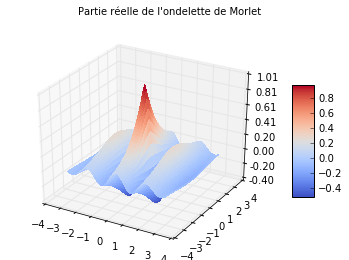

In [3]:
Z = Morlet2D_grid(100, 100, 4, theta = 3*np.pi/4)
Z_r = np.real(Z)
Z_i = np.imag(Z)
X = np.arange(-100 / 32, 100 / 32, 1/16)
Y = np.arange(-100 / 32, 100 / 32, 1/16)
X, Y = np.meshgrid(X, Y)
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z_r, rstride=1, cstride=1, cmap = cm.coolwarm,
        linewidth=0, antialiased=False)
ax.set_zlim(-0.4, 1.01)


ax.zaxis.set_major_locator(LinearLocator(8))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.suptitle("Partie réelle de l'ondelette de Morlet")
plt.show()

## Convolution 

In [4]:
def morl_conv(image, subsample = 1, J = 0, theta = 0, sigma = 0.85, xi = 3 * np.pi / 4):
    """image of shape (n_lines, n_columns) (levels of grey not RGB), returns convolution with Morlet2D_grid"""
    morlet_filter = Morlet2D_grid(image.shape[0], image.shape[1], J, theta, sigma, xi)
    return (signal.fftconvolve(image, morlet_filter, mode = "same")[ :: subsample,  ::subsample])

In [9]:
# Loads MNIST dataset
mndata = MNIST(os.path.join(os.getcwd(), 'MNIST'))
mnist_images = mndata.load_training()

In [10]:
sample_size = 3000
train_set = [np.array(mnist_images[0][i]).reshape(28,28) for i in range(sample_size)]
y = [mnist_images[1][i] for i in range(sample_size)]

Label : 3


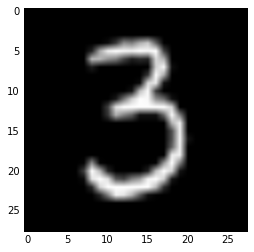

In [11]:
f = np.array(mnist_images[0][50]).reshape(28,28)
plt.imshow(f, cmap=plt.cm.gray)
print('Label : ' + str(mnist_images[1][50]))

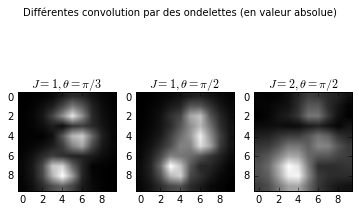

In [142]:
fig = plt.figure()
f1 = np.abs(morl_conv(f,subsample = 3, J = 1, theta = np.pi/3))
f2 = np.abs(morl_conv(f, subsample = 3, J = 1, theta = np.pi/2))
f3 = np.abs(morl_conv(f, subsample = 3, J = 2, theta = np.pi/2))

a = fig.add_subplot(1, 3, 1)
plt.imshow(f1, cmap = plt.cm.gray)
a.set_title(r"$J=1, \theta=\pi/3$")

a = fig.add_subplot(1, 3, 2)
plt.imshow(f2, cmap = plt.cm.gray)
a.set_title(r"$J=1, \theta=\pi/2$")

a = fig.add_subplot(1, 3, 3)
plt.imshow(f3, cmap = plt.cm.gray)
a.set_title(r"$J=2, \theta=\pi/2$")


fig.suptitle('Différentes convolution par des ondelettes (en valeur absolue)')

## Computing Scattering coeffs

In [143]:
def cascade_wavelet_transf(image, j_path, theta_path):
    """js_path is the dilatations 2**-j we want to compute, thetas_path is similarly thetas path for the rotations 
    returns U[p]: see Mallat article """
    U = image.copy()
    for j, theta in zip(j_path, theta_path):
        U = np.abs(morl_conv(U, J = j, theta = theta))
    return U    

In [144]:
def scattering_paths(J, m, K):
    """ returns a list of all paths = [(j_path, theta_path)] of length M with j_path[k]<j_path[k+1]<= J
        and theta = 2 * np.pi * k, k < K"""
    thetas = [2 * np.pi * k / K for k in range(K)]
    js_path = [list(comb) for comb in combinations(range(1, J + 1), m)]
    thetas_paths = [[theta] for theta in thetas]
    scat_path = []
    for i in range(m - 1):
        new_th_paths = []
        for j in range(len(thetas_paths)):
            for theta in thetas:
                new_th_paths.append(thetas_paths[j] + [theta])
        thetas_paths = new_th_paths
    for j_path in js_path:
        for th_path in thetas_paths:
            scat_path.append((j_path, th_path))
    return scat_path

In [145]:
def scatter_coeffs_long(image, m, K, J = 0, alpha = 1/2):
    
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations
    too long"""
    if J == 0:
        J = int(math.log(image.shape[0], 2))
    print(J)
    scat_coeffs = {}
    for i in range(1, m + 1):
        scat_coeffs[i] = []
        for path in scattering_paths(J, i, K):
            U_path = cascade_wavelet_transf(image, path[0], path[1])
            S_U_path = 1/2**J*ndimage.filters.gaussian_filter(U_path, 1/2**J)
            scat_coeffs[i].append(S_U_path) #vérifier que c'est toujous les mêmes
    print(len(scat_coeffs[1]), len(scat_coeffs[2]))
    return scat_coeffs
            

In [146]:
def continue_path(path, J, K):
    """gets a scattering path of length m, outputs a list of all paths of length m+1 that you could obtain from this path"""
    cont_paths = []
    
    if type(path[0]) == int: #du au fait qu'un tuple ne peut pas avoir une longueur de 1
        j_m = path[0]
    else:
        j_m = path[-1][0]
    thetas = [np.pi * k / K for k in range(K)]
    for j in range(j_m + 1, J + 1):
        for theta in thetas:
            if type(path[0]) == int:
                path1 = [path]
            else:
                path1 = list(path)
            path1 += [(j, theta)]
            cont_paths.append(tuple(path1))
    return cont_paths

continue_path(((1,2),(2, 3*np.pi)), 5, 3)

[((1, 2), (2, 9.42477796076938), (3, 0.0)),
 ((1, 2), (2, 9.42477796076938), (3, 1.0471975511965976)),
 ((1, 2), (2, 9.42477796076938), (3, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (4, 0.0)),
 ((1, 2), (2, 9.42477796076938), (4, 1.0471975511965976)),
 ((1, 2), (2, 9.42477796076938), (4, 2.0943951023931953)),
 ((1, 2), (2, 9.42477796076938), (5, 0.0)),
 ((1, 2), (2, 9.42477796076938), (5, 1.0471975511965976)),
 ((1, 2), (2, 9.42477796076938), (5, 2.0943951023931953))]

In [147]:
def scatter_coeffs_fast(image, m, K, J = 0):
    """J = number of dilatations, m = length of the scattering conv network, K = number of rotations"""
    if J == 0 :
        J = int(math.log(image.shape[0], 2))
    scat_coeffs = 1/2**J*ndimage.filters.gaussian_filter(image, 1/2**J)[ :: 2**J, :: 2**J].reshape(-1)
    path_index = 0
    coeff_indexes = {path_index : (0, scat_coeffs.shape[0])}
    normalization_coeff = {path_index : np.linalg.norm(scat_coeffs)}
    paths_values = {path_index : 0}
    paths = []
    U_p = {1 : {}}
    for j in range(1, J +1):
        for theta in [np.pi * k / K for k in range(K)]:
            path = (j, theta)
            paths.append((path))
            U_p[1][path] = np.abs(morl_conv(image, subsample = path[0], J = path[0], theta = path[1]))
    for i in range(1, m):
        U_p[i+1] = {}
        paths2 = []
        for path in paths:
            path_index += 1
            new_coeff = (1/2**J*ndimage.filters.gaussian_filter(U_p[i][path], 1/2**J)[ :: 2**J, :: 2**J]).reshape(-1)
            scat_coeffs = np.concatenate((scat_coeffs, new_coeff))
            coeff_indexes[path_index] = (scat_coeffs.shape[0] - new_coeff.shape[0], scat_coeffs.shape[0])
            paths_values[path_index] = path
            normalization_coeff[path_index] = np.linalg.norm(new_coeff)
            for next_path in continue_path(path, J, K):
                U_p[i+1][next_path] =  np.abs(morl_conv(image, subsample = next_path[-1][0], J = next_path[-1][0], theta = next_path[-1][1]))
                paths2.append(next_path)
        paths = paths2
    for path in paths:
        path_index += 1
        new_coeff = 1/2**J*ndimage.filters.gaussian_filter(U_p[m][path], 1/2**J).reshape(-1)
        scat_coeffs = np.concatenate((scat_coeffs, new_coeff))
        coeff_indexes[path_index] = (scat_coeffs.shape[0] - new_coeff.shape[0], scat_coeffs.shape[0])
        normalization_coeff[path_index] = np.linalg.norm(new_coeff)
        paths_values[path_index] = path
    return (scat_coeffs, coeff_indexes, normalization_coeff)

In [137]:
%lprun -f morl_conv scatter_coeffs_fast(f, 3, 6)

In [150]:
X = []
d = {}
for i in range(len(train_set)):
    if i%100 == 0:
        print(i)
    scat_coeff, coeff_index, norm_coeff = scatter_coeffs_fast(train_set[i], m=2, K=6, J=3)
    X.append(scat_coeff)
    for i in norm_coeff:
        if norm_coeff[i] > d.get(i,0):
            d[i] = norm_coeff[i]

X = np.array(X)
X_normalized = np.array(X.shape)
for i in coeff_index:
    X_normalized[coeff_index[i][0]:coeff_index[i][1]] = X[coeff_index[i][0]:coeff_index[i][1]] / d[i]

0


KeyboardInterrupt: 

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.70, random_state=42)

In [56]:
param_grid = {'C': [1, 1e2, 1e3, 5e3, 1e4, 5e4, 1e5], 'gamma': [0.001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10]}
clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf0.fit(X_train, y_train)
print("Best estimator found by grid search : ", clf.best_estimator_)

Best estimator found by grid search :  SVC(C=5000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [63]:
param_grid = {'C': [ 4e3, 4500, 5e3, 5500, 6e3,], 'gamma': [1e-6, 1e-5, 0.0001, 0.0005, 0.001]}
clf0 = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf0.fit(X_train, y_train)
print("Best estimator found by grid search : ", clf.best_estimator_)

Best estimator found by grid search :  SVC(C=4500, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [64]:
clf = SVC(kernel='rbf', C=4500, gamma=0.0001)
clf.fit(X_train, y_train)

SVC(C=4500, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [122]:
y_pred = clf.predict(X_test)
print('Accuracy score :', skmetrics.accuracy_score(y_pred, y_test))
print('Confusion matrix :', skmetrics.confusion_matrix(y_pred, y_test))

AttributeError: 'tuple' object has no attribute 'predict'